In [1]:
!git clone https://github.com/Omidzarexz/crispy-computing-machine


Cloning into 'crispy-computing-machine'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 55 (delta 26), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (55/55), 16.15 MiB | 3.39 MiB/s, done.
Resolving deltas: 100% (26/26), done.


In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt


# df_clean_train_12feature_cross_subject = pd.read_csv("/kaggle/working/crispy-computing-machine/df_clean_train_12feature_cross_subject.csv")
# df_clean_test_12feature_cross_subject  = pd.read_csv("/kaggle/working/crispy-computing-machine/df_clean_test_12feature_cross_subject.csv")


# df_clean_train_16feature_cross_subject = pd.read_csv("/kaggle/working/crispy-computing-machine/df_clean_train_16feature_cross_subject.csv")
# df_clean_test_16feature_cross_subject  = pd.read_csv("/kaggle/working/crispy-computing-machine/df_clean_test_16feature_cross_subject.csv")


df_clean_train_16feature_within_subject = pd.read_csv("/kaggle/working/crispy-computing-machine/df_clean_train_16feature_within_subject_txt25.csv")
df_clean_test_16feature_within_subject  = pd.read_csv("/kaggle/working/crispy-computing-machine/df_clean_test_16feature_within_subject_txt25.csv")

df_clean_train_last = pd.read_csv("/kaggle/working/crispy-computing-machine/df_clean_train_last.csv")
df_clean_test_last  = pd.read_csv("/kaggle/working/crispy-computing-machine/df_clean_test_last.csv")

df_clean_train = df_clean_train_last
df_clean_test  = df_clean_test_last

In [3]:
from scipy.signal import butter, filtfilt

def low_pass_butter(signal, cutoff=10, fs=100, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)
feature_columns = [
    'MPU1_Acc_X', 'MPU1_Acc_Y', 'MPU1_Acc_Z',
    'MPU1_Gyro_X', 'MPU1_Gyro_Y', 'MPU1_Gyro_Z',
    'MPU1_Roll','MPU1_Pitch',
    'MPU2_Acc_X', 'MPU2_Acc_Y', 'MPU2_Acc_Z',
    'MPU2_Gyro_X', 'MPU2_Gyro_Y', 'MPU2_Gyro_Z',
    'MPU2_Roll','MPU2_Pitch'
]

# feature_columns = [
#     'MPU1_Acc_X', 'MPU1_Acc_Y', 'MPU1_Acc_Z',
#     'MPU1_Gyro_X', 'MPU1_Gyro_Y', 'MPU1_Gyro_Z',
    
#     'MPU2_Acc_X', 'MPU2_Acc_Y', 'MPU2_Acc_Z',
#     'MPU2_Gyro_X', 'MPU2_Gyro_Y', 'MPU2_Gyro_Z',
    
# ]


df_filtered_trainig = pd.DataFrame()
df_filtered_test    = pd.DataFrame()
for col in feature_columns:
    df_filtered_trainig[col] = low_pass_butter( df_clean_train[col].values
                                        , cutoff=5 # Hz
                                        , fs=100  # Hz
                                        , order=2  )
    df_filtered_test[col] = low_pass_butter( df_clean_test[col].values
                                        , cutoff=5 # Hz
                                        , fs=100  # Hz
                                        , order=2  )






print("\ndf_filtered_trainig shape:",df_filtered_trainig.shape)
print("\ndf_filtered_test shape:",df_filtered_test.shape)



df_filtered_trainig shape: (104394, 16)

df_filtered_test shape: (492, 16)


In [4]:

from sklearn.preprocessing import  MinMaxScaler







scaler = MinMaxScaler(feature_range=(-1, 1))
X_data_train = scaler.fit_transform(df_filtered_trainig[feature_columns].values)  # (T, 12)


y_scaler = MinMaxScaler(feature_range=(-1, 1))
y_data_train = y_scaler.fit_transform(df_clean_train['angle'].values.reshape(-1, 1))





X_data_test = scaler.transform(df_filtered_test[feature_columns].values)

y_data_test = y_scaler.transform(df_clean_test["angle"].values.reshape(-1,1))


# تنظیمات پنجره
window_size = 200   # 
horizon = 1        #
step_size = 5      # 

# تابع پنجره‌بندی
def create_windows_with_labels(X, y, window_size, horizon, step_size):
    X_windows = []
    y_windows = []
    for i in range(0,  len(X) - window_size - horizon + 1, step_size):
        X_windows.append(X[i:i + window_size])
        y_windows.append(y[i + window_size : i + window_size + horizon])  # برچسب آخرین نمونه در پنجره
    return np.array(X_windows), np.array(y_windows)

# ایجاد پنجره‌ها
X_windows, y_windows = create_windows_with_labels(X_data_train, y_data_train,
                                                  window_size, horizon, step_size)
if horizon==1:
    y_windows = y_windows.reshape(-1,1)




print(f"✅   (X_windows):(samples, time steps, features) → {X_windows.shape}")
print(f"✅  (y_windows): {y_windows.shape}")

step_size_for_test = 1
X_windows_test, y_windows_test = create_windows_with_labels(X_data_test, y_data_test,
                                                            window_size, horizon, step_size_for_test)

if horizon==1:
    y_windows_test = y_windows_test.reshape(-1,1)

print(f"\n✅   (X_windows_test):(samples, time steps, features) → {X_windows_test.shape}")
print(f"✅  (y_windows_test): {y_windows_test.shape}")






✅   (X_windows):(samples, time steps, features) → (20839, 200, 16)
✅  (y_windows): (20839, 1)

✅   (X_windows_test):(samples, time steps, features) → (292, 200, 16)
✅  (y_windows_test): (292, 1)


2025-10-17 17:57:25.744371: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760723845.938250      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760723845.995888      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1760723859.196207      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


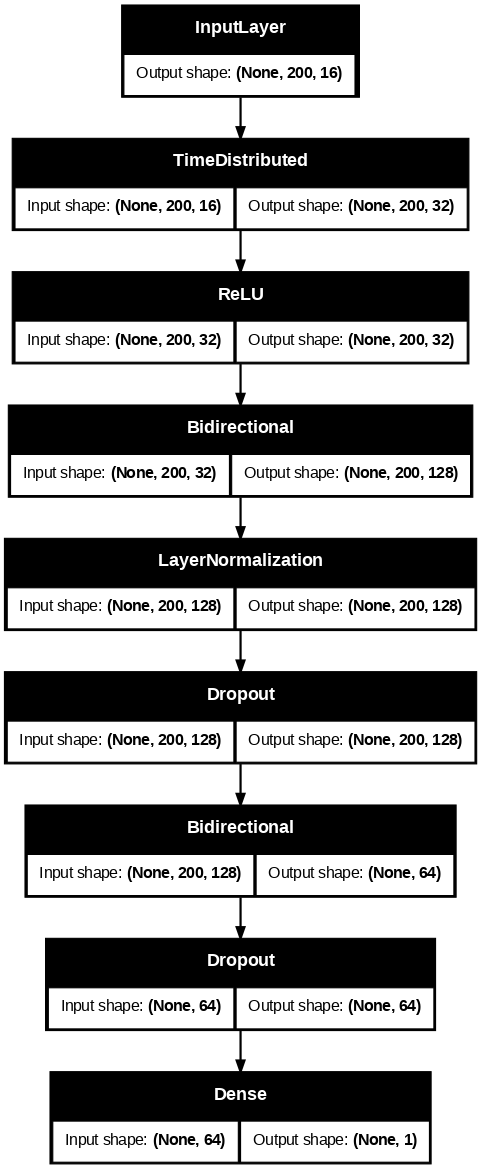

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from keras.layers import Bidirectional

from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, GlobalAveragePooling1D
from tensorflow.keras.layers import Input, Dense, GRU, Bidirectional, Dropout, ReLU, TimeDistributed, LayerNormalization
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2

LEARNING_RATE = 0.001
lambda_loss_amount = 0.0005



def build_bi_lstm_model(input_shape, horizon=1, lambda_loss_amount=1e-4, learning_rate=1e-3):
    inputs = Input(shape=input_shape, name="input")

    # Dense projection per timestep
    x = TimeDistributed(Dense(32, kernel_regularizer=l2(lambda_loss_amount)))(inputs)
    x = ReLU()(x)

    # Stacked BiGRU layers
    x = Bidirectional(LSTM(64, return_sequences=True,
                           kernel_regularizer=l2(lambda_loss_amount)))(x)
    x = LayerNormalization()(x)
    x = Dropout(0.3)(x)

    x = Bidirectional(LSTM(32, return_sequences=False,
                           kernel_regularizer=l2(lambda_loss_amount)))(x)
    x = Dropout(0.3)(x)

    # Output
    outputs = Dense(horizon, activation='linear')(x)

    # Model compile
    model = Model(inputs=inputs, outputs=outputs, name="BiLSTM_reg")
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
                  loss='mse',
                  metrics=['mae'])
    return model

final_model = build_bi_lstm_model(input_shape=(X_windows.shape[1],X_windows.shape[2]))

# final_model.summary()

plot_model(final_model, show_shapes=True , dpi=80)

In [5]:
# ## transfer learning

# import matplotlib.pyplot as plt
# from tensorflow.keras.models import load_model
# from sklearn.metrics import  mean_absolute_error
# import tensorflow as tf




# base_model = load_model('/kaggle/input/m2_lstm_16eatue_cross_subject_1horizon/tensorflow2/default/1/m2_lstm_16eatue_cross_subject.keras')


# # Freeze early layers (optional)
# for layer in base_model.layers[:-3]:
#     layer.trainable = False



# # Recompile
# base_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mse', metrics=['mae'])



# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# from sklearn.model_selection import train_test_split


# #X_train, X_val, y_train, y_val = train_test_split( X_windows, y_windows, test_size=0.2,
#  #                                                  shuffle=False, random_state=42)


# callbacks = [
#     ModelCheckpoint('best_lstm_model_reg.keras', save_best_only=True, monitor='loss',verbose=1),
#     EarlyStopping(monitor='loss', patience=50, restore_best_weights=True,verbose=1),
#     ReduceLROnPlateau(monitor='loss', factor=0.5, patience=15, min_lr=5e-6,verbose=1)
# ]

# history_ft = base_model.fit(
#     X_windows, y_windows,
#     #validation_data=(X_val, y_val),
#     epochs=500,
#     batch_size=64,
#     callbacks=callbacks,
#     verbose=1
# )

2025-10-17 17:36:01.557422: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760722561.765532      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760722561.822770      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1760722574.012658      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/500


I0000 00:00:1760722587.632290     109 cuda_dnn.cc:529] Loaded cuDNN version 90300


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2082 - mae: 0.3732
Epoch 1: loss improved from inf to 0.15554, saving model to best_lstm_model_reg.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - loss: 0.2072 - mae: 0.3722 - learning_rate: 1.0000e-04
Epoch 2/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0790 - mae: 0.2351
Epoch 2: loss improved from 0.15554 to 0.06923, saving model to best_lstm_model_reg.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0788 - mae: 0.2349 - learning_rate: 1.0000e-04
Epoch 3/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0450 - mae: 0.1809
Epoch 3: loss improved from 0.06923 to 0.04082, saving model to best_lstm_model_reg.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0449 - mae: 0.1807 - learning_rate: 1.0000e-04
Epoch 4/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0310 - mae: 0.1451
Epoch 4: loss improved from 0.04082 to 0.02824, saving model to best_lstm_model_reg.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step 

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split


X_train, X_val, y_train, y_val = train_test_split( X_windows, y_windows, test_size=0.2,
                                                   shuffle=False, random_state=42)


callbacks = [
    ModelCheckpoint('best_lstm_model_reg.keras', save_best_only=True, monitor='val_loss',verbose=1),
    EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True,verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=5e-6,verbose=1)
]

history = final_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=500,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)



Epoch 1/500


I0000 00:00:1760723904.537383     108 cuda_dnn.cc:529] Loaded cuDNN version 90300


260/261 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.1371 - mae: 0.2264
Epoch 1: val_loss improved from inf to 0.05617, saving model to best_lstm_model_reg.keras
261/261 ━━━━━━━━━━━━━━━━━━━━ 37s 75ms/step - loss: 0.1367 - mae: 0.2259 - val_loss: 0.0562 - val_mae: 0.1276 - learning_rate: 0.0010
Epoch 2/500
260/261 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0502 - mae: 0.1079
Epoch 2: val_loss improved from 0.05617 to 0.04313, saving model to best_lstm_model_reg.keras
261/261 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - loss: 0.0502 - mae: 0.1078 - val_loss: 0.0431 - val_mae: 0.1036 - learning_rate: 0.0010
Epoch 3/500
260/261 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0367 - mae: 0.0854
Epoch 3: val_loss did not improve from 0.04313
261/261 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - loss: 0.0367 - mae: 0.0854 - val_loss: 0.0434 - val_mae: 0.1218 - learning_rate: 0.0010
Epoch 4/500
260/261 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0296 - mae: 0.0754
Epoch 4: val_loss improved from 0.04313 to 0.02747

In [9]:
    from tensorflow.keras.models import load_model
    from sklearn.metrics import  mean_absolute_error
    
    
    # model = load_model('best_lstm_model_reg.keras')
    # پیش‌بینی روی داده تست
    y_pred_scaled = final_model.predict(X_windows_test)  # (N, 1)
    
    # برگرداندن به مقیاس اصلی
    y_pred_original = y_scaler.inverse_transform(y_pred_scaled)
    y_true_original = y_scaler.inverse_transform(y_windows_test)  
    
    
    
    
    mae = mean_absolute_error(y_true_original, y_pred_original)
    mae2 = mean_absolute_error(y_windows_test, y_pred_scaled)
    
    print(f"Test MAE(scaled): {mae2:.3f}")
    print(f"Test MAE(true value): {mae:.3f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 358ms/step
Test MAE(scaled): 0.037
Test MAE(true value): 0.768


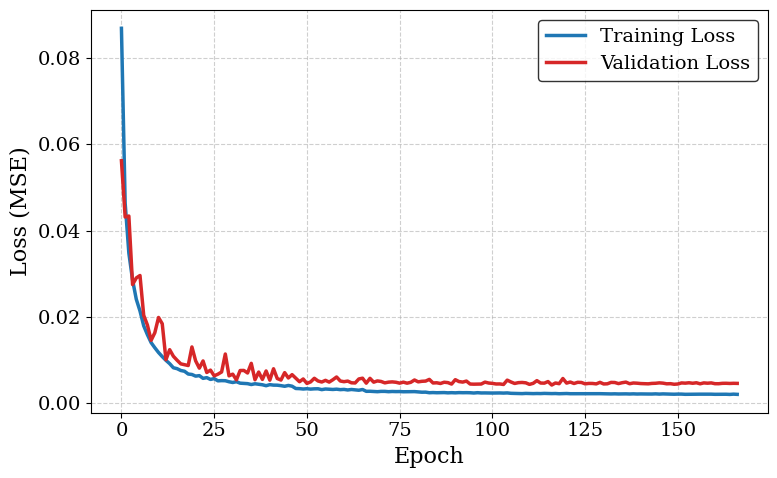

In [10]:
import matplotlib.pyplot as plt

# Set font sizes and styles for publication
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'font.family': 'serif',  # Optional: use serif font (common in papers)
    'figure.figsize': (8, 5)
})

# Plot training & validation loss
plt.plot(history.history["loss"], label="Training Loss", linewidth=2.5, color='tab:blue')
plt.plot(history.history["val_loss"], label="Validation Loss", linewidth=2.5, color='tab:red')

# Add title and axis labels
# plt.title("Model Training Progress", fontsize=18, pad=20)
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")

# Improve layout and add grid
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend(frameon=True, loc='upper right', shadow=False, edgecolor='black')

# Use tight layout to prevent clipping
plt.tight_layout()

# Save high-resolution figure for your article
plt.savefig("loss_cross_subject.png", dpi=300, bbox_inches='tight')
# plt.savefig("training_validation_loss.png", format='png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
import pickle

with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [11]:
y_pred_original.shape

(292, 1)

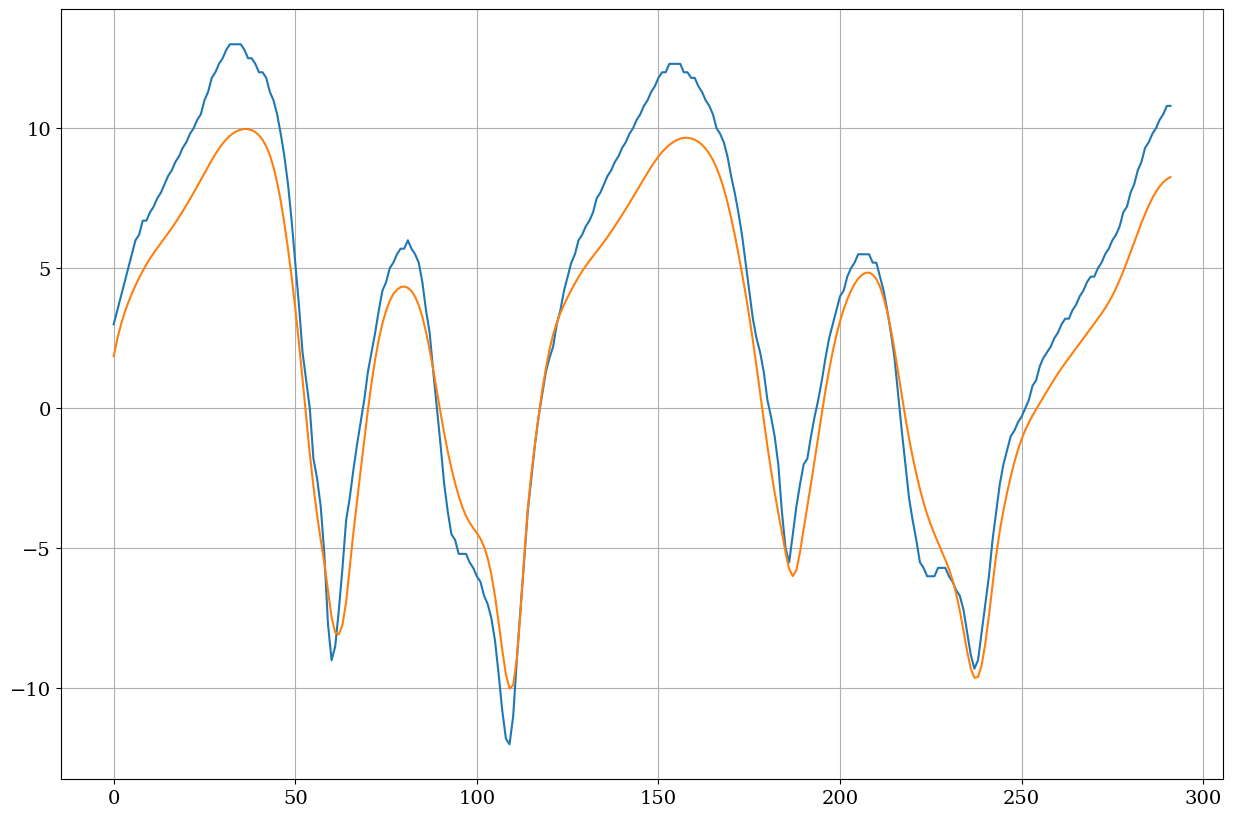

In [22]:

n1=9200
n2=9900
plt.figure(figsize=(15,10))
plt.plot(y_true_original)
plt.plot(y_pred_original)
plt.grid()


    # y_pred_original = y_scaler.inverse_transform(y_pred_scaled)
    # y_true_original = y_scaler.inverse_transform(y_windows_test) 


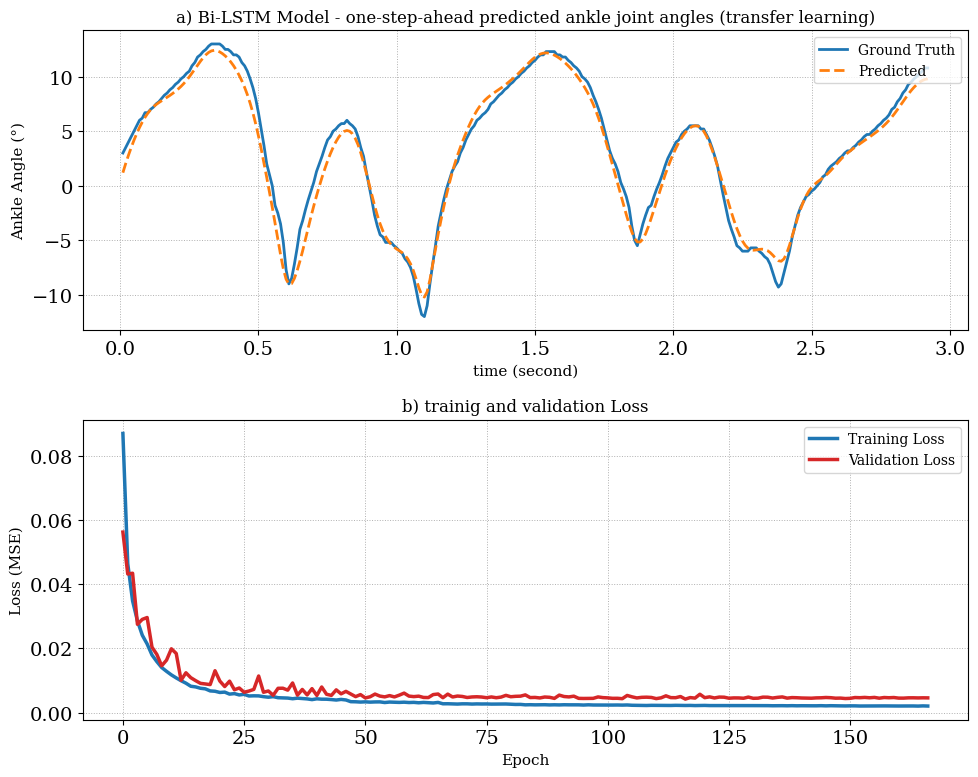

In [13]:
import matplotlib.pyplot as plt

# Define segment range
n1, n2 = 0, 292

# Create figure and subplots
plt.figure(figsize=(10, 8))

# --- Subplot 1 ---
plt.subplot(2, 1, 1)


time = np.arange(1, y_true_original.shape[0]+1) * 0.01
time = time.reshape(-1, 1) 

plt.plot(time[n1:n2] , y_true_original[n1:n2], label='Ground Truth', linewidth=2, color='#1f77b4')
plt.plot(time[n1:n2] , y_pred_original[n1:n2], label='Predicted', linestyle='--', linewidth=2, color='#ff7f0e')
plt.title('a) Bi-LSTM Model - one-step-ahead predicted ankle joint angles (transfer learning)', fontsize=12)
plt.xlabel('time (second)', fontsize=11)

plt.ylabel('Ankle Angle (°)', fontsize=11)
plt.grid(True, linestyle=':', linewidth=0.7)
plt.legend(fontsize=10, loc='upper right')

# # --- Subplot 2 ---
plt.subplot(2, 1, 2)
# plt.plot(time[n1:n2] , y_true_original12[n1:n2], label='Ground Truth', linewidth=2, color='#1f77b4')
# plt.plot(time[n1:n2] , y_pred_original12[n1:n2], label='Predicted', linestyle='--', linewidth=2, color="#ff7f0e")
# plt.title('(b) Bi-LSTM Model - 12 Features', fontsize=12)

plt.plot(history.history["loss"], label="Training Loss", linewidth=2.5, color='tab:blue')
plt.plot(history.history["val_loss"], label="Validation Loss", linewidth=2.5, color='tab:red')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.grid(True, linestyle=':', linewidth=0.7)
plt.legend(fontsize=10, loc='upper right')
plt.title('b) trainig and validation Loss', fontsize=12)


# Add title and axis labels
# plt.title("Model Training Progress", fontsize=18, pad=20)
plt.xlabel("Epoch", fontsize=11)
plt.ylabel("Loss (MSE)", fontsize=11)
# Adjust layout
plt.tight_layout()
plt.savefig('transfer_learning.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Define segment range
n1, n2 = 0, 292

# Create figure and subplots
plt.figure(figsize=(10, 8))

# --- Subplot 1 ---
plt.subplot(2, 1, 1)


time = np.arange(1, y_true_original.shape[0]+1) * 0.01
time = time.reshape(-1, 1) 

plt.plot(time[n1:n2] , y_true_original[n1:n2], label='Ground Truth', linewidth=2, color='#1f77b4')
plt.plot(time[n1:n2] , y_pred_original[n1:n2], label='Predicted', linestyle='--', linewidth=2, color='#ff7f0e')
plt.title('Bi-LSTM Model - one-step-ahead predicted ankle joint angles', fontsize=12)
plt.ylabel('Ankle Angle (°)', fontsize=11)
plt.grid(True, linestyle=':', linewidth=0.7)
plt.legend(fontsize=10, loc='upper right')

# --- Subplot 2 ---
plt.subplot(2, 1, 2)
plt.plot(time[n1:n2] , y_true_original12[n1:n2], label='Ground Truth', linewidth=2, color='#1f77b4')
plt.plot(time[n1:n2] , y_pred_original12[n1:n2], label='Predicted', linestyle='--', linewidth=2, color="#ff7f0e")
plt.title('(b) Bi-LSTM Model - 12 Features', fontsize=12)
plt.xlabel('time (second)', fontsize=11)
plt.ylabel('Ankle Angle (°)', fontsize=11)
plt.grid(True, linestyle=':', linewidth=0.7)
plt.legend(fontsize=10, loc='upper right')

# Adjust layout
plt.tight_layout()
plt.savefig('12_and_16_feature_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
